In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf


import seaborn as sns
import warnings
import os
from scipy.interpolate import griddata



from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras import datasets, layers, models
from tensorflow import keras
from keras.callbacks import ModelCheckpoint


from skimage import data, img_as_float
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error

import meshio
import re

In [2]:
import cfdnetplus

In [3]:
path_to_main= 'airfoil2d/'
folders=['airFoil_1000', 'airFoil_30', 'airFoil_300','airFoil_600', 'airFoil_3000', 'airFoil_2000']
#folders=['airFoil_1000']
fields= ['U','p','k','omega', 'nut']
xlim =[-50,50]
ylim = [-30 , 30]
xres=256
yres=66
zcut=0.05
modelid='model_mse_rmsprop_newnorm'

In [86]:
cfdnetplus.VTK2np(path_to_main,folders, fields,'xy' ,xres,yres,xlim,ylim,zcut)

processing data in airfoil2d/airFoil_1000/VTK/
(339, 66, 256, 7)
339
[266]
data written toairfoil2d/airFoil_1000/VTK/df
processing data in airfoil2d/airFoil_30/VTK/
(600, 66, 256, 7)
600
[555]
data written toairfoil2d/airFoil_30/VTK/df
processing data in airfoil2d/airFoil_300/VTK/
(338, 66, 256, 7)
338
[265]
data written toairfoil2d/airFoil_300/VTK/df
processing data in airfoil2d/airFoil_600/VTK/
(338, 66, 256, 7)
338
[265]
data written toairfoil2d/airFoil_600/VTK/df
processing data in airfoil2d/airFoil_3000/VTK/
(340, 66, 256, 7)
340
[267]
data written toairfoil2d/airFoil_3000/VTK/df
processing data in airfoil2d/airFoil_2000/VTK/
(340, 66, 256, 7)
340
[267]
data written toairfoil2d/airFoil_2000/VTK/df


['airfoil2d/airFoil_1000/VTK/',
 'airfoil2d/airFoil_30/VTK/',
 'airfoil2d/airFoil_300/VTK/',
 'airfoil2d/airFoil_600/VTK/',
 'airfoil2d/airFoil_3000/VTK/',
 'airfoil2d/airFoil_2000/VTK/']

In [4]:
if 'U' in fields:
    l=len(fields)+2
else:
    l=len(fields)

df = np.empty((0,66,256,l))
df_label = np.empty((0,66,256,l))
path_to_folders=[]
for i in folders:
    path_to_folders.append(path_to_main+i+'/VTK/')
    df_t=np.load(path_to_main+i+'/VTK/df.npy')
    df_tlabel=np.load(path_to_main+i+'/VTK/df_label.npy')
    norm=np.amax(abs(df_t), axis=(0,1,2))
    df=np.concatenate((df,df_t*(1/norm)))
    df_label=np.concatenate((df_label,df_tlabel*(1/norm)))
print(df_label.shape)

(2295, 66, 256, 7)


In [5]:

Ux_max=np.max(abs(df[:,:,:,[0]]))
Uy_max=np.max(abs(df[:,:,:,[1]]))
p_max=np.max(abs(df[:,:,:,[3]]))
k_max=np.max(abs(df[:,:,:,[4]]))
omega_max=np.max(abs(df[:,:,:,[5]]))
nut_max=np.max(abs(df[:,:,:,[6]]))
#normal=[Ux_max,Uy_max,0,p_max,k_max,omega_max,nut_max]
#print(normal)

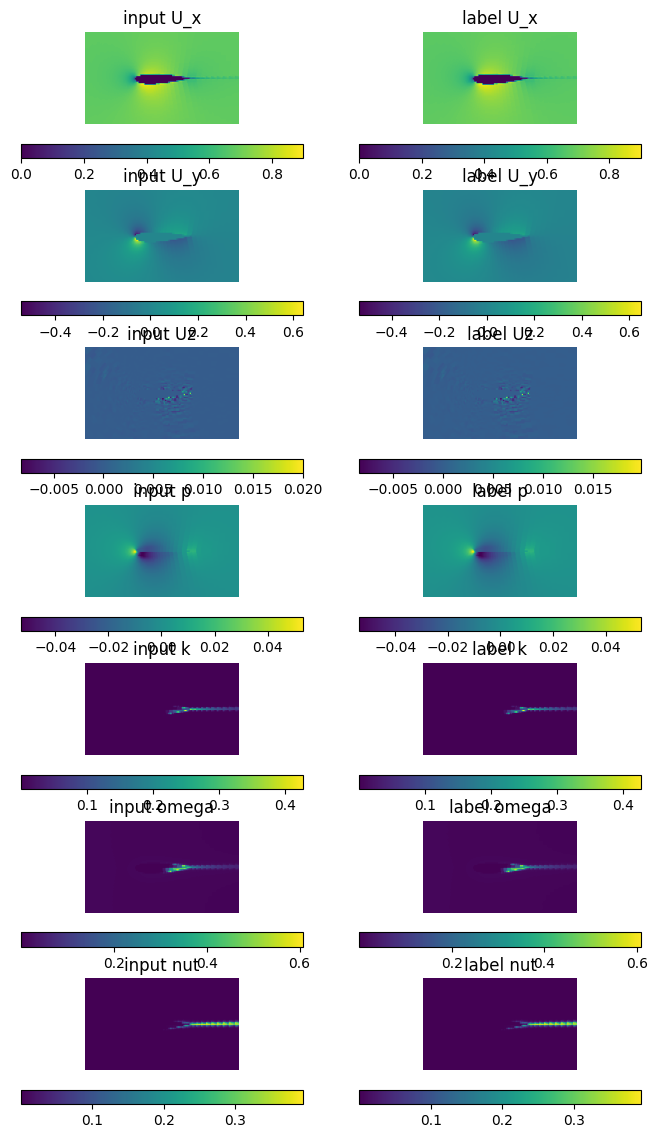

In [6]:

n=100
fig = plt.figure(figsize=(8, 14))
[a,b,c,d]=df.shape
titles= ['U_x','U_y','Uz','p','k','omega','nut']

for i in range(d):
    fig.add_subplot(d, 2, i*2+1)
    plt.imshow(df[n,:,:,i],extent=[xlim[0],xlim[1],ylim[0],ylim[1]])
    plt.title('input ' +titles[i])
    plt.axis('off')
    plt.colorbar(location='bottom')
    
    fig.add_subplot(d, 2, i*2+2)
    plt.imshow(df_label[n,:,:,i],extent=[xlim[0],xlim[1],ylim[0],ylim[1]])
    plt.title('label '+titles[i])
    plt.axis('off')
    plt.colorbar(location='bottom')
    #print(i)

plt.show()

In [265]:
#normalise U Vektors


Ux_max=np.max(abs(df[:,:,:,[0]]))
Uy_max=np.max(abs(df[:,:,:,[1]]))
p_max=np.max(abs(df[:,:,:,[3]]))
k_max=np.max(abs(df[:,:,:,[4]]))
omega_max=np.max(abs(df[:,:,:,[5]]))
nut_max=np.max(abs(df[:,:,:,[6]]))

model_path='cfdnetplus_models/'+modelid+'/'
normal=np.array([Ux_max,Uy_max,0,p_max,k_max,omega_max,nut_max]).reshape(1,1,1,l)
print(normal)

if os.path.isdir(model_path)== False:
    os.mkdir(model_path)
np.save(model_path+'normal',normal)
print(model_path+'')

[[[[4.41323047e+03 2.61715942e+03 0.00000000e+00 7.33556320e+07
    2.83279031e+05 1.93653164e+04 4.86423264e+01]]]]
cfdnetplus_models/model_sep/


In [7]:
contents=''
for field in fields:
    contents=contents+field+ '\n'
print(contents)
with open(model_path+'fields',"w") as f:
            f.writelines(contents)
dims=np.array([xres,yres,xlim[0],xlim[1],ylim[0],ylim[1],zcut])
np.save(model_path+'dims',dims)

U
p
k
omega
nut



NameError: name 'model_path' is not defined

In [8]:
train_data, test_data, label_train, label_test = train_test_split (df, df_label, test_size = 0.15)

20


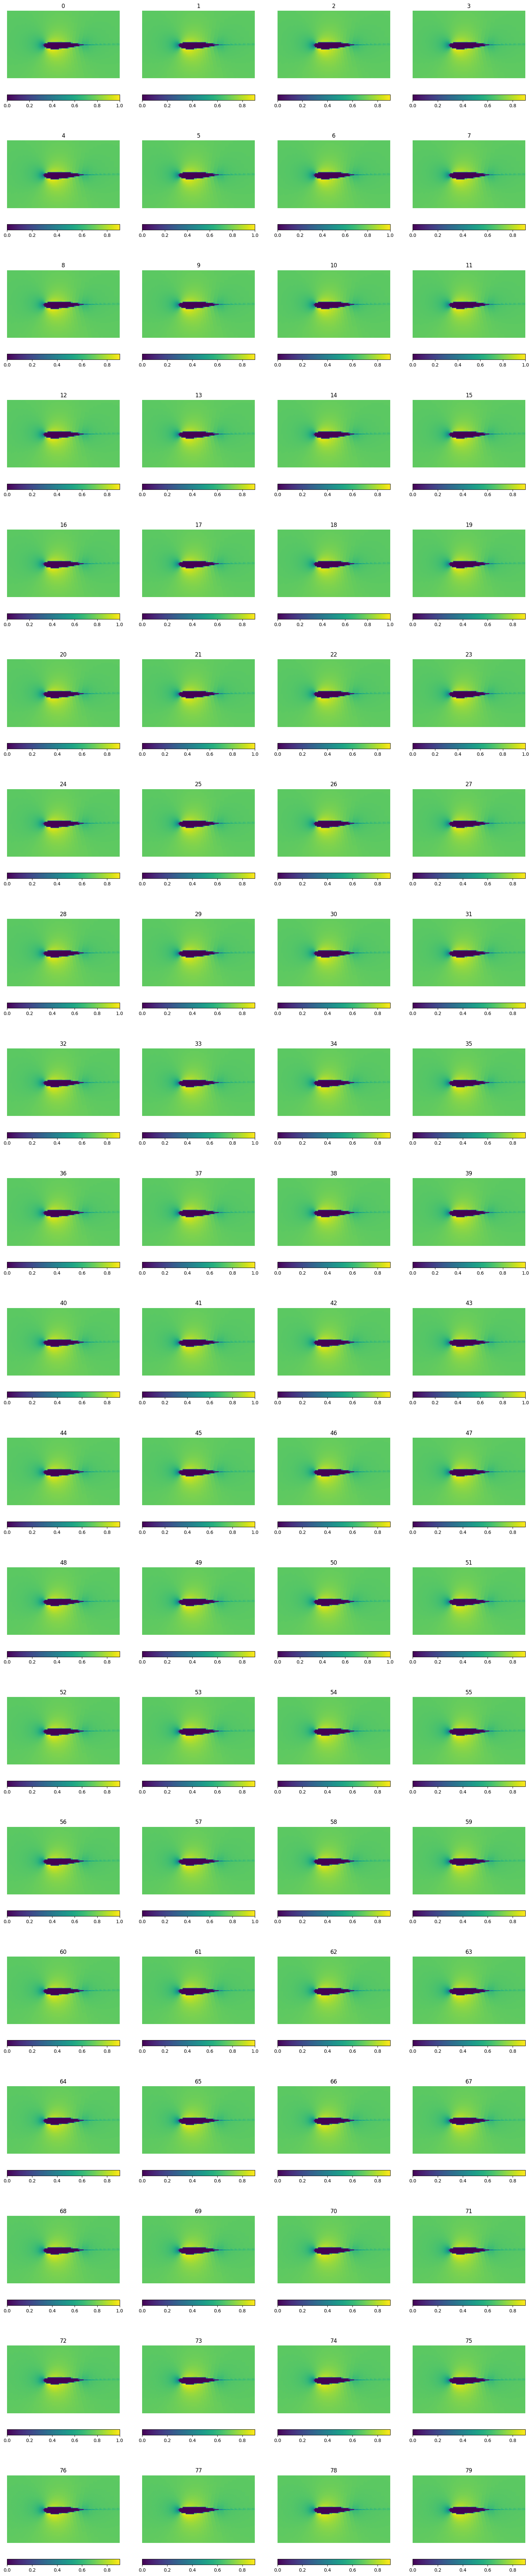

In [9]:
[a,b,c,d]=label_train.shape
fig = plt.figure(figsize=(20, 100))
columns = 4
rows = 20
print(rows)

for i in range( columns * rows):
    img = label_train[(i-1),:,:,0]
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(img,extent=[xlim[0],xlim[1],ylim[0],ylim[1]])
    plt.title(i)
    plt.axis('off')
    plt.colorbar(location='bottom')

plt.show()

In [10]:
[a,b,c,d]=df.shape

In [11]:
# Valid for input with four layers
model = models.Sequential()
model.add(layers.Conv2D(16,( 4,12), (2, 8), activation='tanh',padding="same", input_shape=(66,256, d)))
model.add(layers.Conv2D(64,(6), (3, 4), activation='tanh',padding="same",))
model.add(layers.Conv2D(256,(16,12), (11, 8), activation='tanh',padding="same",))
model.add(layers.Conv2DTranspose(32,(14,10),(11,8), activation='tanh',padding="same"))
model.add(layers.Conv2DTranspose(16,(6,8),(3,4), activation='tanh',padding="same"))
model.add(layers.Conv2DTranspose(d,(4,16),(2,8), activation='linear', padding="same"))

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 33, 32, 16)        5392      
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 8, 64)         36928     
                                                                 
 conv2d_2 (Conv2D)           (None, 1, 1, 256)         3145984   
                                                                 
 conv2d_transpose (Conv2DTra  (None, 11, 8, 32)        1146912   
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 33, 32, 16)       24592     
 ranspose)                                                       
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 66, 256, 7)       7

In [13]:
model.compile(optimizer='RMSProp',
              loss='mse')

In [14]:
folders=os.listdir('training/')
print(folders)
sub='training_'
folders = [x for x in folders if re.search(sub, x)]
#print(len(folders))
if len(folders)==0:
    filefolder=sub+'0'
else:
    id=[]
    for txt in folders:
        t=txt.split('_')
        id.append(int(t[len(t)-1]))
    index_max=np.argmax(id)
    filefolder= sub+str(id[index_max]+1)
print(filefolder)

['training_0', 'training_23', 'training_24', 'training_25', 'training_26', 'training_27', 'training_28', 'training_29', 'training_30', 'training_31', 'training_32', 'training_33', 'training_34', 'training_35', 'training_36', 'training_37', 'training_38']
training_39


In [15]:
filepath ='training/'+ filefolder+'/'+'vae_best_model_relu.epoch{epoch:02d}-loss{loss:.5f}.w'
checkpoint = ModelCheckpoint(filepath=filepath, 
                             monitor='loss',
                             verbose=1,
                             save_weights_only=True,
                             save_best_only=True,
                             mode='min')
callbacks = [checkpoint]

In [16]:
history = model.fit(train_data, label_train, epochs=100, 
                    validation_data=(test_data, label_test),
                    batch_size=32,
                   callbacks=callbacks)

Epoch 1/100
61/61 [==============================] - ETA: 0s - loss: 0.0078
Epoch 1: loss improved from inf to 0.00781, saving model to training/training_39\vae_best_model_relu.epoch01-loss0.00781.w
61/61 [==============================] - 17s 266ms/step - loss: 0.0078 - val_loss: 0.0024
Epoch 2/100
61/61 [==============================] - ETA: 0s - loss: 0.0022
Epoch 2: loss improved from 0.00781 to 0.00223, saving model to training/training_39\vae_best_model_relu.epoch02-loss0.00223.w
61/61 [==============================] - 16s 262ms/step - loss: 0.0022 - val_loss: 0.0020
Epoch 3/100
61/61 [==============================] - ETA: 0s - loss: 0.0018
Epoch 3: loss improved from 0.00223 to 0.00180, saving model to training/training_39\vae_best_model_relu.epoch03-loss0.00180.w
61/61 [==============================] - 16s 260ms/step - loss: 0.0018 - val_loss: 0.0014
Epoch 4/100
61/61 [==============================] - ETA: 0s - loss: 0.0016
Epoch 4: loss improved from 0.00180 to 0.00156, s

61/61 [==============================] - ETA: 0s - loss: 2.6566e-04
Epoch 29: loss improved from 0.00029 to 0.00027, saving model to training/training_39\vae_best_model_relu.epoch29-loss0.00027.w
61/61 [==============================] - 17s 272ms/step - loss: 2.6566e-04 - val_loss: 3.1566e-04
Epoch 30/100
61/61 [==============================] - ETA: 0s - loss: 2.6600e-04
Epoch 30: loss did not improve from 0.00027
61/61 [==============================] - 16s 263ms/step - loss: 2.6600e-04 - val_loss: 2.5857e-04
Epoch 31/100
61/61 [==============================] - ETA: 0s - loss: 2.5311e-04
Epoch 31: loss improved from 0.00027 to 0.00025, saving model to training/training_39\vae_best_model_relu.epoch31-loss0.00025.w
61/61 [==============================] - 16s 268ms/step - loss: 2.5311e-04 - val_loss: 3.6704e-04
Epoch 32/100
61/61 [==============================] - ETA: 0s - loss: 2.5646e-04
Epoch 32: loss did not improve from 0.00025
61/61 [==============================] - 17s 272ms/

Epoch 59/100
61/61 [==============================] - ETA: 0s - loss: 1.3272e-04
Epoch 59: loss improved from 0.00014 to 0.00013, saving model to training/training_39\vae_best_model_relu.epoch59-loss0.00013.w
61/61 [==============================] - 17s 283ms/step - loss: 1.3272e-04 - val_loss: 1.2912e-04
Epoch 60/100
61/61 [==============================] - ETA: 0s - loss: 1.3150e-04
Epoch 60: loss improved from 0.00013 to 0.00013, saving model to training/training_39\vae_best_model_relu.epoch60-loss0.00013.w
61/61 [==============================] - 17s 278ms/step - loss: 1.3150e-04 - val_loss: 1.3185e-04
Epoch 61/100
61/61 [==============================] - ETA: 0s - loss: 1.2740e-04
Epoch 61: loss improved from 0.00013 to 0.00013, saving model to training/training_39\vae_best_model_relu.epoch61-loss0.00013.w
61/61 [==============================] - 16s 270ms/step - loss: 1.2740e-04 - val_loss: 1.5361e-04
Epoch 62/100
61/61 [==============================] - ETA: 0s - loss: 1.2854e-0

61/61 [==============================] - ETA: 0s - loss: 9.4930e-05
Epoch 88: loss did not improve from 0.00009
61/61 [==============================] - 16s 268ms/step - loss: 9.4930e-05 - val_loss: 7.6797e-05
Epoch 89/100
61/61 [==============================] - ETA: 0s - loss: 9.2421e-05
Epoch 89: loss did not improve from 0.00009
61/61 [==============================] - 17s 283ms/step - loss: 9.2421e-05 - val_loss: 1.2377e-04
Epoch 90/100
61/61 [==============================] - ETA: 0s - loss: 9.1688e-05
Epoch 90: loss improved from 0.00009 to 0.00009, saving model to training/training_39\vae_best_model_relu.epoch90-loss0.00009.w
61/61 [==============================] - 16s 269ms/step - loss: 9.1688e-05 - val_loss: 8.1816e-05
Epoch 91/100
61/61 [==============================] - ETA: 0s - loss: 9.1288e-05
Epoch 91: loss improved from 0.00009 to 0.00009, saving model to training/training_39\vae_best_model_relu.epoch91-loss0.00009.w
61/61 [==============================] - 18s 289ms/

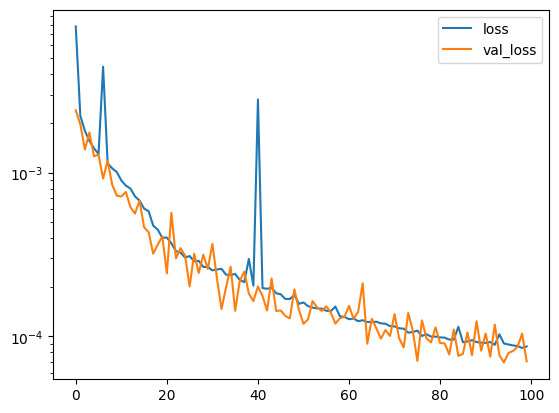

In [17]:
plt.plot(history.history['loss'], label = 'loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
#plt.xlabel('Epoch')
#plt.ylabel('loss')
#plt.ylim([0.5, 1])
plt.yscale('log')
plt.legend(loc='upper right')

Finding the last epoch in the training folder

In [18]:
#filefolder= 'training_6'

folders=os.listdir('training/'+filefolder)
#folders=os.listdir('training/'+'training_0/')

sub='index'
folders = [x for x in folders if re.search(sub, x)]

ts=[]
for folder in folders:
    a=re.search('\d{2,3}',folder)
    ts.append(int(a.group(0)))
    #print(a.group(0))
index_max=np.max(ts)
print(index_max)
latest = [x for x in folders if re.search(str(index_max), x)]

latest=latest[0].split('.index')
print(latest[0])

99
vae_best_model_relu.epoch99-loss0.00009.w


In [19]:
weights_path='training/'+filefolder+'/'+latest[0]

#weights_path='training/'+'training_0'+'/'+latest[0]

print(weights_path)
model.load_weights(weights_path)

training/training_39/vae_best_model_relu.epoch99-loss0.00009.w


In [20]:
test=model.predict(test_data)

11/11 [==============================] - 1s 55ms/step


In [22]:
print(label_test.shape[0])
n=0
print('max:' , np.max(test[:,:,:,n]))
print('min:' , np.min(test[:,:,:,n]))
#label_test=label_test.reshape((36,66,256,4))
#plt.imshow(np.clip(label_test[1,:,:,3],0,1))

345
max: 0.951485
min: -0.0706712


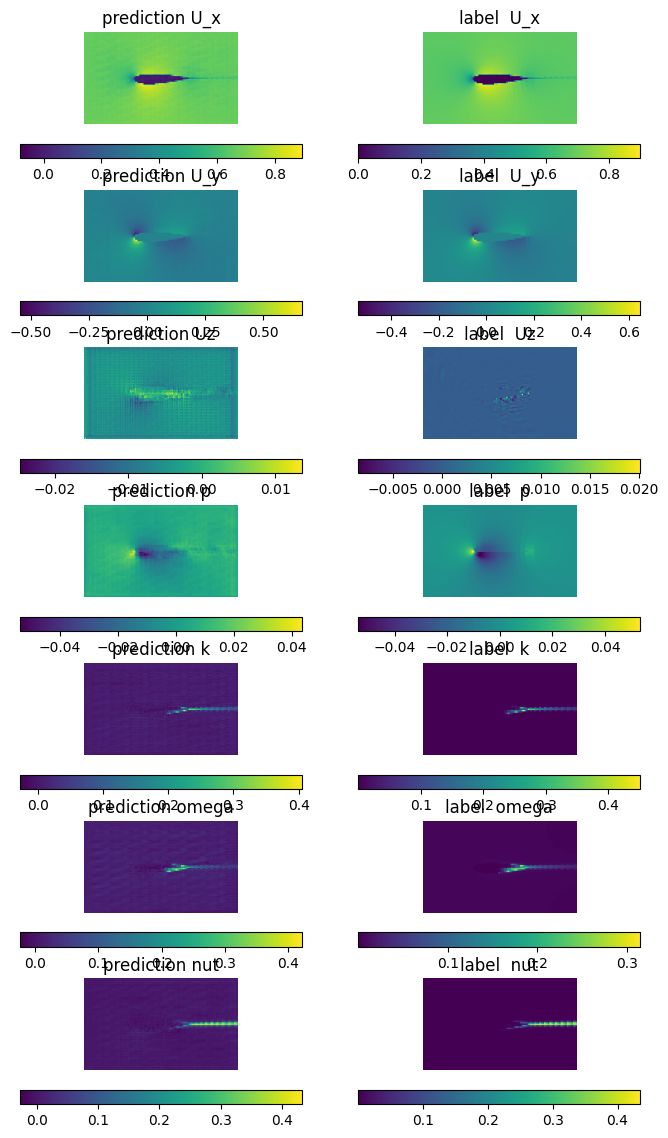

In [21]:
n=40
fig = plt.figure(figsize=(8, 14))
[a,b,c,d]=test.shape
#titles= ['Ux','Uy','Uz','p']
titles= ['U_x','U_y','Uz','p','k','omega','nut']

for i in range(d):
    fig.add_subplot(d, 2, i*2+1)
    plt.imshow(test[n,:,:,i],extent=[xlim[0],xlim[1],ylim[0],ylim[1]])
    plt.title('prediction ' +titles[i])
    plt.axis('off')
    plt.colorbar(location='bottom')
    
    fig.add_subplot(d, 2, i*2+2)
    plt.imshow(label_test[n,:,:,i],extent=[xlim[0],xlim[1],ylim[0],ylim[1]])
    plt.title('label  '+titles[i])
    plt.axis('off')
    plt.colorbar(location='bottom')
    #print(i)

plt.show()

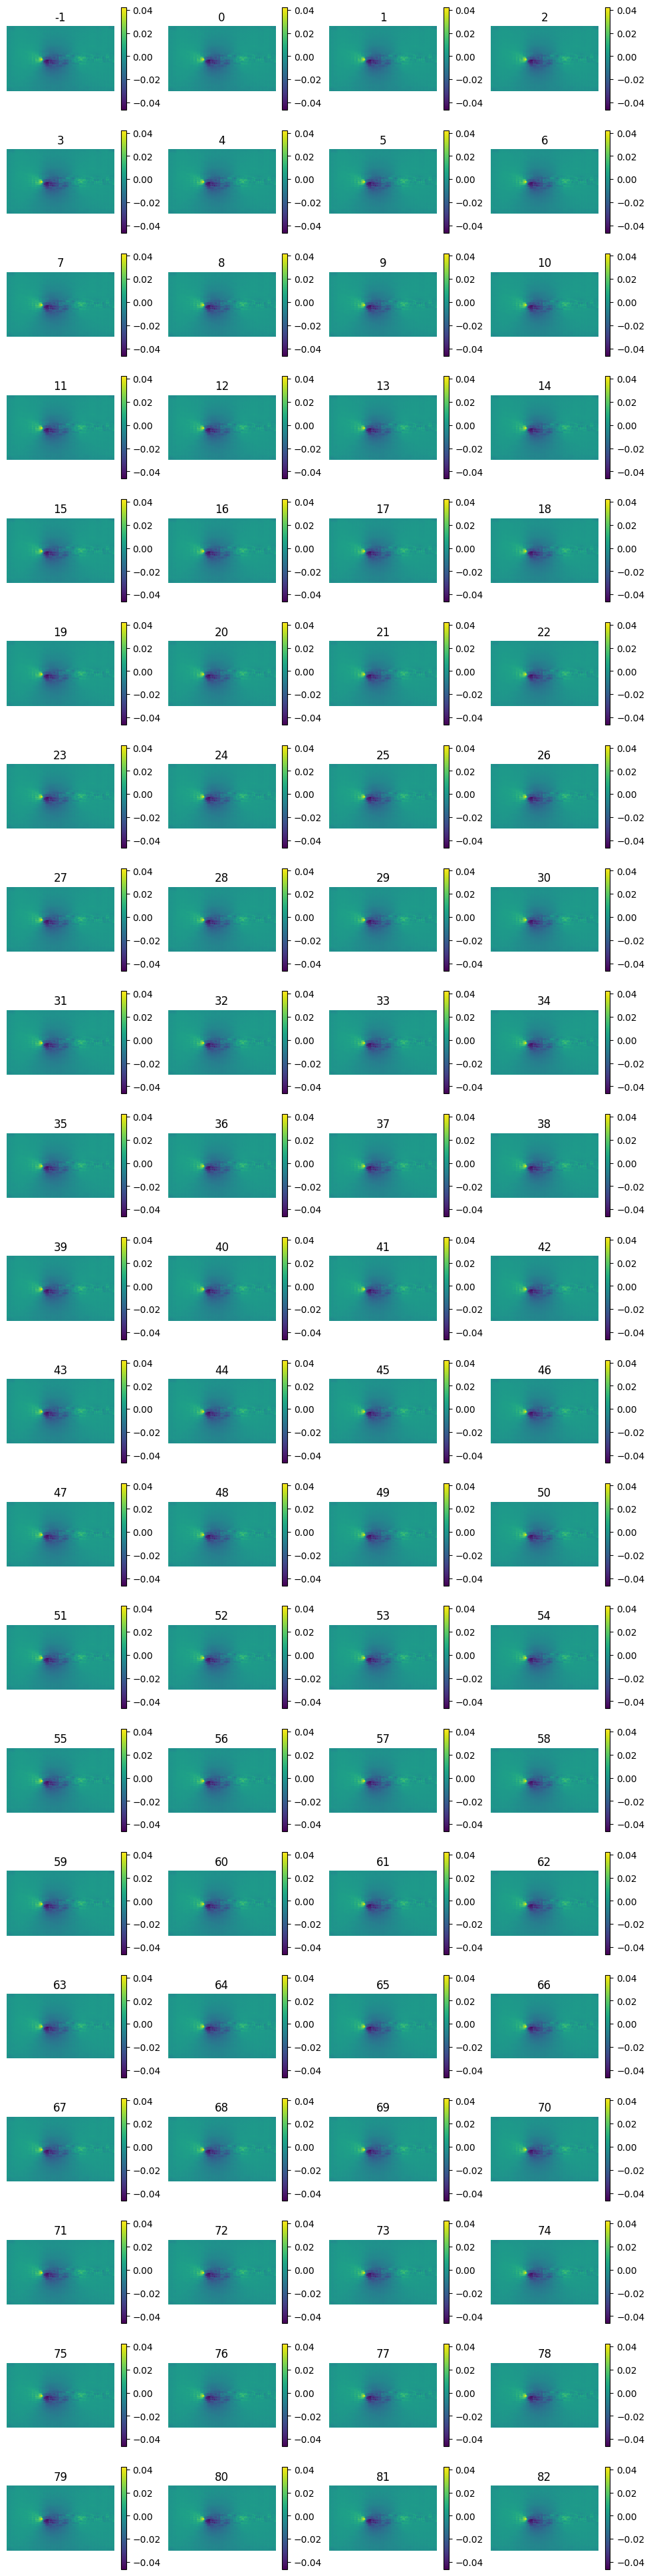

In [66]:
[a,b,c,d]=test.shape
fig = plt.figure(figsize=(12, 50))
columns = 4
rows = 21

for i in range( columns * rows):
    img = test[(i-1),:,:,3]
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(img,extent=[xlim[0],xlim[1],ylim[0],ylim[1]])
    plt.title(i-1)
    plt.axis('off')
    plt.colorbar()
plt.show()

In [149]:
mse=[]
ssim1=[]
for i in range(label_test.shape[0]):
    mse.append(mean_squared_error(test[i,:,:,0],label_test[i,:,:,0]))
    ssim1.append(ssim(test[i,:,:,0],label_test[i,:,:,0]))
print('max mse:'+ str(max(mse)))
print(ssim1[n])
print(mse[n])
mse=np.mean(mse)
ssim2=np.mean(ssim1[:])
print('average ssim: '+str(ssim2))
print('average mse: '+str(mse))

C:\Users\hansi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\skimage\_shared\utils.py:348: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  return func(*args, **kwargs)


max mse:2.7152526887379602e-05
0.999943384540081
1.0341332323513827e-07
average ssim: 0.9998922086021752
average mse: 2.634276224574286e-07


In [22]:
print('model saved to: '+'cfdnetplus_models/'+modelid)
model.save('cfdnetplus_models/'+modelid)

model saved to: cfdnetplus_models/model_mse_rmsprop_newnorm


INFO:tensorflow:Assets written to: cfdnetplus_models/model_mse_rmsprop_newnorm\assets


INFO:tensorflow:Assets written to: cfdnetplus_models/model_mse_rmsprop_newnorm\assets
